In [1]:
import logging
from copy import deepcopy

import torch
from torchensemble import VotingRegressor

from modeling import Imager, InitialBeam, QuadScanTransport
from torch.utils.data import DataLoader, Dataset, random_split

logging.basicConfig(level=logging.INFO)
from image_processing import import_images

location = (
    "D:\\AWA\\phase_space_tomography_07_07_22" "\\Quadscan_data_matching_solenoid_180A"
)
base_fname = location + "\\DQ7_scan1_"

all_k, all_images, all_charges, xx = import_images()
all_charges = torch.tensor(all_charges)
all_images = torch.tensor(all_images)
all_k = torch.tensor(all_k)
print(all_images.shape)


# create data loader
class ImageDataset(Dataset):
    def __init__(self, k, images):
        self.images = images
        self.k = k

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.k[idx], self.images[idx]


def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        # torch.nn.init.xavier_uniform_(m.bias, gain=1.0)


class QuadScanModel(torch.nn.Module):
    def __init__(self, initial_beam, transport, imager):
        super(QuadScanModel, self).__init__()
        self.beam_generator = deepcopy(initial_beam)
        self.lattice = transport
        self.imager = imager

        self.beam_generator.apply(init_weights)

    def forward(self, K, custom_beam=None):
        initial_beam = self.beam_generator(custom_beam)
        output_beam = self.lattice(initial_beam, K)
        output_coords = torch.cat(
            [output_beam.x.unsqueeze(0), output_beam.y.unsqueeze(0)]
        )
        output_images = self.imager(output_coords)
        return output_images


defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(65.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

train_dset = torch.load("train.dset")
test_dset = torch.load("test.dset")

train_dataloader = DataLoader(train_dset, batch_size=2)
test_dataloader = DataLoader(test_dset)

# define model components and model
bins = xx[0].T[0]
bandwidth = torch.tensor(1.0e-4)

module_kwargs = {
    "initial_beam": InitialBeam(100000, n_hidden=2, width=50, **defaults),
    "transport": QuadScanTransport(torch.tensor(0.12),torch.tensor(2.84 + 0.54)),
    "imager": Imager(bins, bandwidth)
}

ensemble = VotingRegressor(
    estimator=QuadScanModel,
    estimator_args=module_kwargs,
    n_estimators=2,
    n_jobs=1
)


class CustomLoss(torch.nn.MSELoss):
    pass

criterion = CustomLoss()
ensemble.set_criterion(criterion)

ensemble.set_optimizer(
    "Adam",
    lr=0.001
)

from torchensemble.utils import io
io.load(ensemble, ".")


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([21, 10, 180, 180])


In [2]:
all_k.shape

torch.Size([21, 10])

In [3]:
train_k = all_k[train_dset.indices]
train_k = train_k.cuda()

train_im = all_images[train_dset.indices]
train_im = train_im.cpu()

test_k = all_k[test_dset.indices]
test_k = test_k.cuda()

test_im = all_images[test_dset.indices]
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        train_pred = torch.cat([ensemble[i](train_k[:,:1], custom_beam).unsqueeze(0) for i in range(len(ensemble))])
        train_pred = torch.transpose(train_pred.squeeze(), 0,1)
        train_pred = train_pred.cpu().detach()

        test_pred = torch.cat([ensemble[i](test_k[:,:1], custom_beam).unsqueeze(0) for i in range(len(ensemble))])
        test_pred = torch.transpose(test_pred.squeeze(), 0,1)
        test_pred = test_pred.cpu().detach()

        torch.save(train_pred, "train_pred_images.pt")
        torch.save(test_pred, "test_pred_images.pt")
    else:
        train_pred = torch.load("train_pred_images.pt")
        test_pred = torch.load("test_pred_images.pt")

In [5]:
print(test_pred.shape)
print(test_im.shape)


torch.Size([4, 2, 180, 180])
torch.Size([4, 10, 180, 180])


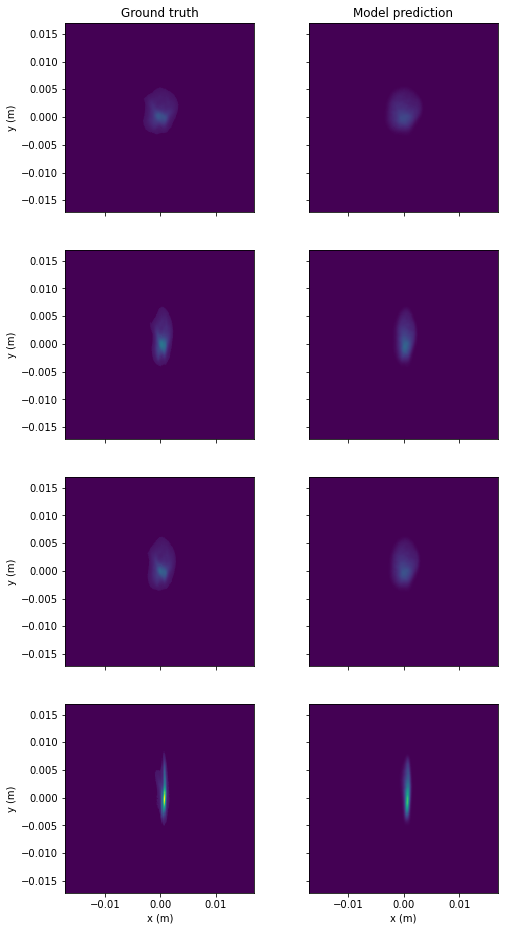

In [6]:
from visualization import compare_images
fig = compare_images(xx, test_pred[:,0], test_im[:,0])
fig.set_size_inches(8,16)

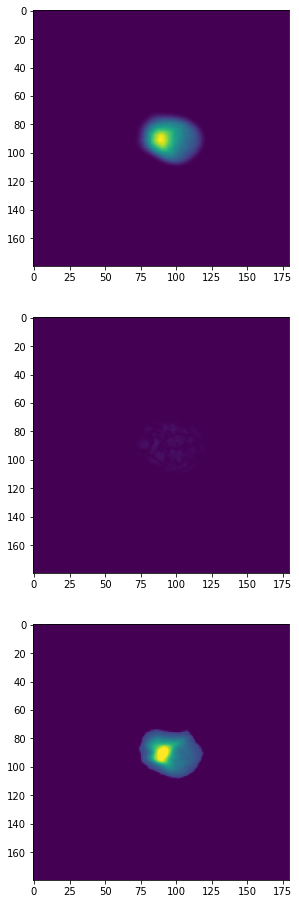

In [7]:
import matplotlib.pyplot as plt

def apply_filter(X):
    return X#ndimage.median_filter(X, size=3)

fig,ax = plt.subplots(3,1)
fig.set_size_inches(8,16)
mean = torch.mean(test_pred, dim=1)[0]
std = torch.std(test_pred, dim=1)[0]
ax[0].imshow(mean, vmax = torch.max(mean))
ax[1].imshow(std, vmax = torch.max(mean))
ax[2].imshow(test_im[0][0], vmax = torch.max(mean))

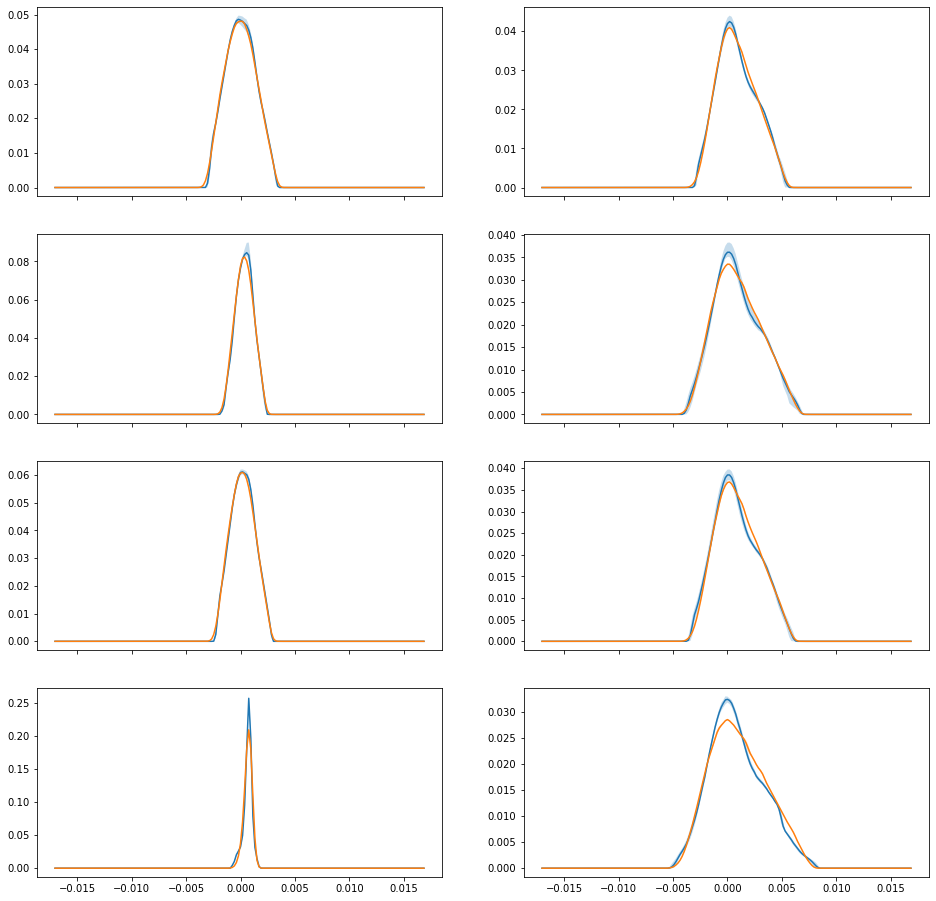

In [8]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], test_im, test_pred)
fig.set_size_inches(16,16)

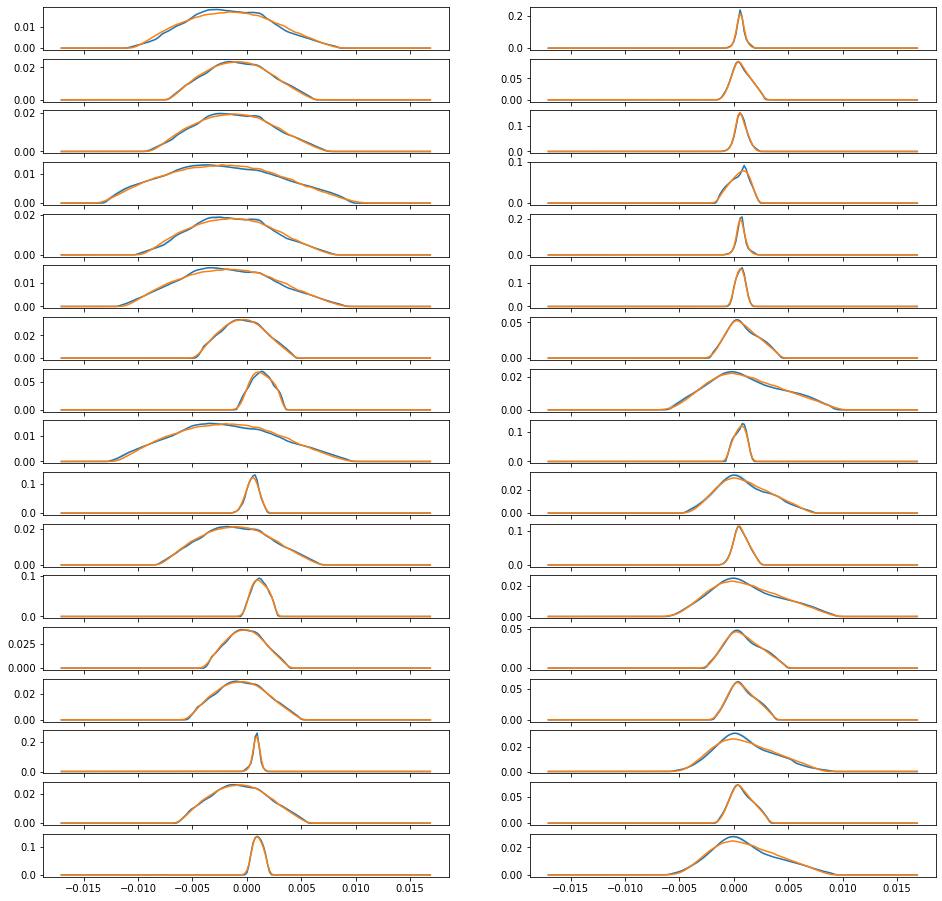

In [9]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], train_im, train_pred)
fig.set_size_inches(16,16)

<AxesSubplot:>

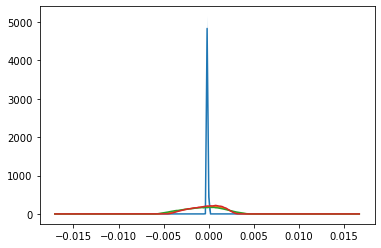

In [10]:
# plot reconstructed beam dist
from visualization import add_projection
beams = [ele.beam_generator() for ele in ensemble]

fig,ax = plt.subplots()
#add_projection(ax, "x", beams, xx[0].T[0])
#add_projection(ax, "y", beams, xx[0].T[0])
#add_projection(ax, "px", beams, xx[0].T[0])
#add_projection(ax, "py", beams, xx[0].T[0])
add_projection(ax, "z", beams, xx[0].T[0])
add_projection(ax, "pz", beams, xx[0].T[0], plot_samples=True)

In [11]:
# plot results from initial_ensemble
# get initial set of estimators
initial_estimators = []
for _ in range(200):
    initial_estimators.append(ensemble._make_estimator())

initial_estimators = torch.nn.ModuleList(initial_estimators)
initial_estimators.load_state_dict(torch.load("initial_ensemble.pt"))

RuntimeError: Error(s) in loading state_dict for ModuleList:
	size mismatch for 0.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 0.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 1.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 1.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 2.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 2.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 3.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 3.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 4.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 4.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 5.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 5.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 6.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 6.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 7.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 7.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 8.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 8.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 9.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 9.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 10.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 10.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 11.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 11.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 12.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 12.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 13.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 13.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 14.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 14.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 15.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 15.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 16.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 16.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 17.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 17.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 18.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 18.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 19.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 19.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 20.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 20.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 21.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 21.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 22.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 22.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 23.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 23.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 24.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 24.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 25.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 25.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 26.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 26.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 27.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 27.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 28.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 28.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 29.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 29.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 30.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 30.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 31.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 31.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 32.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 32.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 33.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 33.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 34.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 34.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 35.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 35.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 36.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 36.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 37.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 37.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 38.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 38.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 39.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 39.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 40.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 40.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 41.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 41.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 42.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 42.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 43.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 43.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 44.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 44.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 45.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 45.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 46.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 46.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 47.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 47.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 48.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 48.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 49.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 49.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 50.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 50.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 51.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 51.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 52.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 52.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 53.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 53.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 54.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 54.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 55.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 55.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 56.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 56.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 57.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 57.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 58.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 58.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 59.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 59.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 60.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 60.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 61.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 61.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 62.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 62.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 63.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 63.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 64.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 64.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 65.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 65.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 66.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 66.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 67.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 67.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 68.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 68.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 69.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 69.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 70.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 70.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 71.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 71.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 72.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 72.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 73.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 73.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 74.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 74.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 75.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 75.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 76.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 76.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 77.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 77.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 78.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 78.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 79.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 79.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 80.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 80.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 81.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 81.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 82.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 82.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 83.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 83.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 84.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 84.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 85.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 85.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 86.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 86.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 87.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 87.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 88.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 88.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 89.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 89.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 90.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 90.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 91.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 91.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 92.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 92.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 93.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 93.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 94.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 94.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 95.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 95.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 96.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 96.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 97.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 97.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 98.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 98.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 99.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 99.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 100.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 100.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 101.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 101.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 102.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 102.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 103.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 103.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 104.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 104.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 105.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 105.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 106.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 106.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 107.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 107.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 108.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 108.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 109.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 109.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 110.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 110.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 111.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 111.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 112.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 112.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 113.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 113.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 114.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 114.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 115.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 115.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 116.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 116.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 117.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 117.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 118.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 118.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 119.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 119.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 120.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 120.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 121.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 121.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 122.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 122.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 123.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 123.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 124.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 124.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 125.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 125.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 126.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 126.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 127.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 127.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 128.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 128.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 129.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 129.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 130.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 130.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 131.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 131.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 132.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 132.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 133.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 133.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 134.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 134.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 135.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 135.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 136.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 136.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 137.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 137.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 138.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 138.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 139.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 139.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 140.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 140.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 141.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 141.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 142.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 142.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 143.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 143.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 144.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 144.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 145.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 145.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 146.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 146.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 147.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 147.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 148.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 148.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 149.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 149.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 150.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 150.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 151.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 151.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 152.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 152.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 153.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 153.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 154.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 154.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 155.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 155.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 156.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 156.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 157.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 157.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 158.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 158.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 159.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 159.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 160.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 160.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 161.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 161.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 162.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 162.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 163.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 163.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 164.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 164.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 165.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 165.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 166.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 166.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 167.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 167.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 168.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 168.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 169.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 169.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 170.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 170.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 171.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 171.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 172.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 172.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 173.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 173.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 174.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 174.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 175.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 175.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 176.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 176.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 177.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 177.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 178.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 178.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 179.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 179.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 180.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 180.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 181.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 181.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 182.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 182.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 183.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 183.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 184.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 184.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 185.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 185.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 186.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 186.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 187.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 187.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 188.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 188.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 189.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 189.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 190.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 190.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 191.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 191.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 192.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 192.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 193.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 193.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 194.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 194.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 195.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 195.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 196.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 196.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 197.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 197.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 198.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 198.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).
	size mismatch for 199.beam_generator.base_distribution_samples: copying a param with shape torch.Size([10000, 6]) from checkpoint, the shape in current model is torch.Size([100000, 6]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.0.weight: copying a param with shape torch.Size([20, 6]) from checkpoint, the shape in current model is torch.Size([50, 6]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.2.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.4.weight: copying a param with shape torch.Size([20, 20]) from checkpoint, the shape in current model is torch.Size([50, 50]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for 199.beam_generator.transformer.linear_tanh_stack.6.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([6, 50]).

In [ ]:
# plot reconstructed beam dist
from visualization import add_projection
initial_beams = [ele.beam_generator() for ele in initial_estimators]

fig,ax = plt.subplots(3,1,sharex="all")
fig.set_size_inches(5,10)
add_projection(ax[0], "z", beams, xx[0].T[0], "_fit")
add_projection(ax[0], "z", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[1], "pz", beams, xx[0].T[0], "_fit")
add_projection(ax[1], "pz", initial_beams, xx[0].T[0], "_initial")

add_projection(ax[2], "x", beams, xx[0].T[0], "_fit")
add_projection(ax[2], "x", initial_beams, xx[0].T[0], "_initial")

for ele in ax:
    ele.legend()
fig.savefig("entropy.png")